In [50]:
%pylab inline
e = 1.602e-19 #electronic charge
h = 6.63e-34 #Planck's constant
e0 = 8.85e-12 #Permittivity of free space
m0 = 9.11e-31 #Free electron mass
kb = 1.381e-23 #Boltsmann's constant
hbar = h/(2*pi)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'Text', 'Button', 'Widget', 'interactive', 'e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import os
import sys
import csv
scripts_path = os.path.abspath(os.path.join('../scripts/'))
data_path = os.path.abspath(os.path.join('../data/'))
sys.path.append(scripts_path)
sys.path.append(data_path)
    

In [3]:
scripts_path

'/home/treharne/Documents/projects/SAZO/scripts'

In [4]:
T_data = data_path + '/T/160616_C_extracted.txt'
R_data = data_path + '/4PP/160616_C.dat'
XPS_data = data_path + '/XPS/160616-C_XPS_100pt_2.csv'

In [5]:
def read_T_data(path):
    f = open (path, 'rb')
    reader = csv.reader(f)
    data = []
    data_dict = {}
    x, y = relabel_T_coords()
    coords = np.transpose([x,y])
   
    for i, line in zip(coords, reader):
       
        item = [float(x) for x in line[0].split(' ')]
        
        data_dict['%s %s' % (i[0], i[1])] = {'x': i[0], 
                                             'y': i[1],
                                             'd': item[2],
                                             'wp': item[3]}
                                            
    return data_dict


In [6]:
def read_R_data(path):
    f = open(path, 'rb')
    reader = csv.reader(f)
    headers = reader.next()
    data = []
    data_dict = {}
    x, y = relabel_T_coords()
    coords = np.transpose([x,y])
    for i, line in zip(coords, reader):
        
        
        
        item = []
        for x in line:
            try:
                item.append(float(x))
                
        
            except:
                item.append(None)
                
        if item[2]:
            item[2] = item[2]*4.532
        
        data_dict['%s %s' % (line[0], line[1])] = {'x': line[0], 
                                                   'y': line[1],
                                                   'Rs': item[2]}
    return data_dict
                                             
        

In [7]:
def relabel_T_coords():
    x = []
    y = []
    for i in range(0, 10):
    
        for j in range(0, 10):
            x.append((j-4.5)*10)
            y.append((4.5-i)*10)
    
    
    return x, y

In [8]:
extracted_T = read_T_data(T_data)
extracted_R = read_R_data(R_data)

In [9]:
def getxyz(data, param):
    count = 0
    x = []
    y = []
    z = []
    for key in data.keys():
        x.append(data.get(key, None).get('x', None))
        y.append(data.get(key, None).get('y', None))
        z.append(data.get(key, None).get(param, None))
    return x, y, z
    
    

In [10]:
def contour_plot(data, param, res=50, scale='linear'):
    x, y, z = getxyz(data, param)
    zlabel = None
    
    if scale == 'log':
        for i in range (0, len(z)):
            try: 
                z[i] = np.log10(z[i])
            except:
                z[i] = None
                
    if param == 'ne':
        zlabel='Carrier Conc., $n_e$ (cm$^{-3}$)'
        for i in range(0, len(z)):
            try:
                z[i] = z[i]/1e20
            except:
                z[i] = None
    elif param =='mob':
        zlabel='Mobility, $\mu_e$ (cm$^{2}$V$^{-1}$s$^{-1}$)'
    elif param =='d':
        zlabel='Film Thickness, $d$ (nm)'
    
    xi = np.linspace(min(x), max(x), res)
    yi = np.linspace(min(y), max(y), res)
    zi = griddata(x, y, z, xi, yi)
    
    fig = figure(figsize=(9,7))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')

    S = ax.contour(xi, yi, zi, 10, colors='k')
    CF = ax.contourf(xi, yi, zi, 50, cmap='gist_rainbow')
    ax.clabel(S, fontsize=15, fmt='%1.1f')
    CB = colorbar(CF,  format='%1.1f')
    CB.ax.tick_params(labelsize=15)
    if zlabel:
        CB.set_label(zlabel, fontsize=18)

    ax.set_xlabel('x (mm)', fontsize=15)
    ax.set_ylabel('y (mm)', fontsize=15)
    ax.tick_params(labelsize=15)

In [11]:
def merge_dict(dict1, dict2):
    dict3 = {}
    for key in dict1.keys():
        d = dict1.get(key).copy()
        d.update(dict2.get(key))
        dict3[key] = d
    return dict3
        
        

In [12]:
merged = merge_dict(extracted_R, extracted_T)

In [13]:
def get_ne(data_dict, mstar = 0.38, varepsilon = 4):
    
    for key in data_dict.keys():
              
        #from wp calculate ne and convert to cm^-3
        #wp currently in units eV
        wpeV = data_dict[key].get('wp')
        wp = (wpeV*e)*2*pi/h
        
        #calculate ne
        
        ne = (wp**2*mstar*m0*e0/e**2)/1e6
        
        #add to original dictionary
        #data_dict[key]['ne'] = ne
        data_dict[key]['ne'] = ne
        
        

In [14]:
def get_rho(data_dict):
    for  key in data_dict.keys():
        Rs = data_dict[key].get('Rs')
        d = data_dict[key].get('d')
        try:
            rho = Rs*(d*1e-7)        
            data_dict[key]['rho'] = rho
        except:
            data_dict[key]['rho'] = None
        
    

In [15]:
get_rho(merged)

In [16]:
def get_mob(data_dict):
    for key in data_dict.keys():
        try:
            rho = data_dict[key].get('rho')
            ne = data_dict[key].get('ne')
            mob = 1/(ne*e*rho)
            data_dict[key]['mob'] = mob
        except:
            data_dict[key]['mob'] = None
            
    

In [17]:
get_ne(merged)
get_mob(merged)

In [18]:

#contour_plot(merged, 'd')


In [19]:
def plot_scatter(data_dict):
    ne = []
    mob = []
    d= []
    cond = []
    for key in data_dict.keys():
        try:
            c = 1/data_dict[key].get('rho') 
            cond.append(c)
            
        
            
            ne.append(data_dict[key].get('ne'))
            mob.append(data_dict[key].get('mob'))
            d.append(data_dict[key].get('d'))
            
            
        except:
            next
        
    fig = figure(figsize=(11,7))
    ax = fig.add_subplot(111)
    sizes = [50]*len(ne)
    
    sc = ax.scatter(ne, mob, c=d, s=sizes)
    ax.set_xlabel('$n_e$ (cm$^{-3}$)', size=18)
    ax.set_ylabel('$\mu_e$ (cm$^{2}$V$^{-1}$s$^{-1}$)', size=18)
    ax.tick_params(labelsize=15)
    CB = colorbar(sc)
    CB.set_label('Thickness, $d$ (nm)', size=18)
    CB.ax.tick_params(labelsize=15)
    
    
    
        
        
    
            

In [20]:

#plot_scatter(merged)

In [21]:
#contour_plot(merged, 'd')

In [22]:
#contour_plot(merged, 'ne')

In [23]:
#contour_plot(merged, 'mob')

In [24]:
def get_XPS(path):
    f = open (path, 'rb')
    reader = csv.reader(f)
    data = []
    data_dict = {}
    #x, y = relabel_T_coords()
    header = reader.next()
    print header
       
   
    for line in reader:
        
        
        item = [float(x) for x in line[:3]]
        
        
        
        data_dict['%s %s' % (item[0], item[1])] = {'x': item[0], 
                                                   'y': item[1],
                                                   'z': item[2]}
                                             #'wp': item[3]}
                                            
    return data_dict
    

In [25]:
comp = get_XPS(XPS_data)


['x', 'y', '', 'C 1s at%', 'O 1s at%', 'Zn 2p at%', 'Cl 2p at%', 'S 2p at%', '', '', '']


do nothing
do nothing
do nothing


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

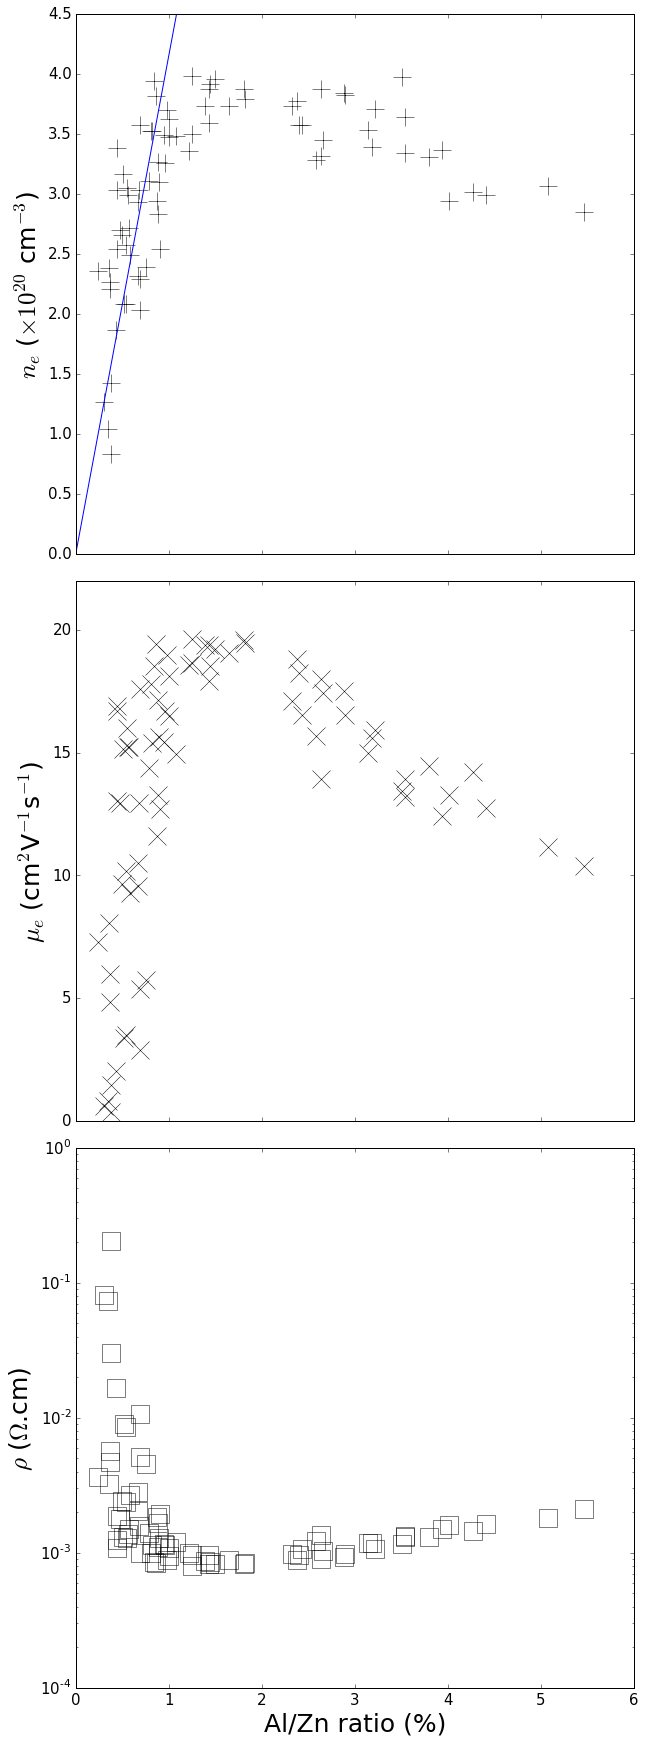

In [26]:

x = []
n = []
mob = []
rho = []
for item in comp:
    c = comp[item].get('z', None)*100
    ln = merged[item].get('ne', None)/1e20
    
    if (c>1 and ln<2):
        print 'do nothing'
    else:
        x.append(comp[item].get('z', None)*100)
        n.append(merged[item].get('ne', None)/1e20)
        mob.append(merged[item].get('mob', None))
        rho.append(merged[item].get('rho', None))


xx = np.linspace(0,0.06,100)

yy = []
nZnO = 81.408
nAl = 26.981
rhoZnO = 5.61

for i in range(len(xx)):
    yy.append((xx[i]*(rhoZnO/nZnO))*6.022e23)
    



f, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10,30))
f.subplots_adjust(hspace=0.05)

ax1.plot(x,n, '+', markersize=18, color='black')
ax1.set_ylim([0, 4.5])
ax1.set_ylabel(r'$n_e$ ($\times10^{20}$ cm$^{-3}$)', fontsize = 25, color='black')
ax1.plot(np.array(xx)*100,np.array(yy)/1e20, '-')
ax2.plot(x,mob, 'x', markersize=18, color='black')
ax2.set_ylim([0, 22])
ax2.set_ylabel(r'$\mu_e$ (cm$^{2}$V$^{-1}$s$^{-1}$)', fontsize = 25, color='black')
ax3.plot(x,rho,'s', markersize=18, color='black', fillstyle='none')
ax3.set_ylabel(r'$\rho$ ($\Omega$.cm)', fontsize=25)
ax3.set_yscale('log')
ax3.set_xlabel('Al/Zn ratio (%)', fontsize = 25)
ax1.tick_params(labelsize = 15)
ax2.tick_params(labelsize = 15)
ax3.tick_params(labelsize = 15)

plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    
#fig = figure(figsize=(7,7))
#fig2 = figure(figsize=(9,7))
#ax = fig.add_subplot(111)
#ax3 = ax.twinx()
#ax2 = fig2.add_subplot(111)
#ax.plot(x,n, 'o')
#ax.plot(np.array(xx)*100,yy)
#ax3.plot(x,mob, 'o', color='red')
#ax.set_yscale('log')
#ax.set_xlim([0,5])
#ax.set_ylim([0,5e20])
#S =ax2.scatter(n,mob,c=x, s=50)
#CB = colorbar(S)
    
    

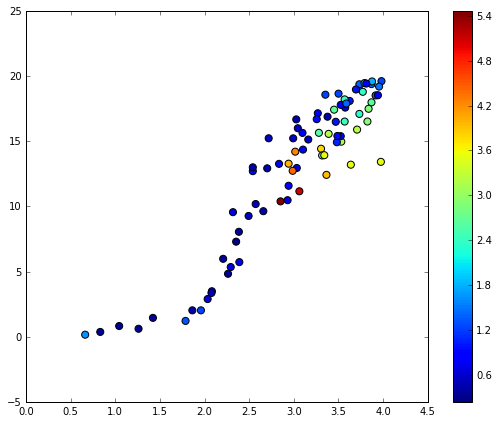

In [160]:
x = []
n = []
mob = []
rho = []
for item in comp:
    c = comp[item].get('z', None)*100
        
    if (c>6):
        print 'do nothing'
    else:
        x.append(comp[item].get('z', None)*100)
        n.append(merged[item].get('ne', None)/1e20)
        mob.append(merged[item].get('mob', None))
        rho.append(merged[item].get('rho', None))

fig = figure(figsize=(9,7))
ax = fig.add_subplot(111)
S =ax.scatter(n,mob,c=x, s=50)
CB = colorbar(S)


In [180]:
#build an app to fit extended seto model

def seto(x, nt, L, R=0, muii=0):
    
    einf = 4.0
    T = 300
    
    mu0 = (e*L)/(sqrt(2*pi*0.38*m0*kb*T)) #internal mobility m2V-1s-1
    
    phiB = ((e**2*nt)/(8*einf*e0*array(x)*1e6)) # Barrier height in J

    museto = 1e4*mu0*exp(-(phiB/(kb*T))) # Seto intergrain mobility cm2V-1s-1
    
    BM = (hbar**2*(3*pi**2*array(x)*1e26)**(2.0/3))/(2*m0*0.38)
    
    Rn = (R/1e13)*(array(x)*1e26)**(1.0/2)
    
    muext = 1e4*mu0*(exp(-(phiB/(kb*T)))+exp((BM-Rn-2*(phiB))/(kb*T)))
    
    mu = (1.0/(muext)+1.0/(muii))**(-1)
    
    
    
    return museto, muext, mu
    

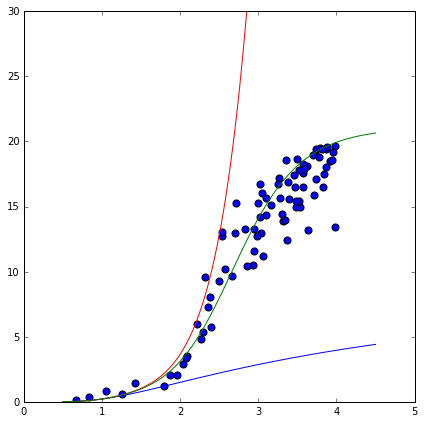

In [181]:
def plotnvsmob(nt, L, R, muii):
    x = linspace (0.5,4.5, 100)
    fig = figure(figsize(7,7))
    ax = fig.add_subplot(111)
    museto, muext, mu = seto(x, nt*1e14, L*1e-9, R=R*1.602e-19, muii=muii)
    ax.plot(x, museto, '-')
    ax.plot(x, muext, '-', color='red')
    ax.plot(x, mu, '-', color='green')
    ax.set_ylim([0,30])
    S =ax.scatter(n,mob, s=50)
    
from ipywidgets import *
nt_s = FloatSlider(min=0.01, max=10, step=0.01, value = 2)
L_s = FloatSlider(min = .001, max = 2, step=0.0001, value = 1.0)
R_s = FloatSlider(min=0, max=1, step = 0.01, value = 0.22)
muii_s = FloatSlider(min=0.1, max=40, step=1, value = 30)


interactive(plotnvsmob, nt=nt_s, L=L_s, R=R_s, muii=muii_s)


